**Uncomment the cell below if running on Google Colab or Kaggle**

In [ ]:
# %%capture
# !pip3 install -U torch torchvision torchaudio
# !pip3 install -U fastai

**Import Dependencies**

In [1]:
from fastai.vision.all import *

In [2]:
import inspect
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def inspect_default_args(target, annotations: bool=False):
    # Get the argument names
    args = inspect.getfullargspec(target).args
    # Get the default values
    defaults = inspect.getfullargspec(target).defaults

    index = ["Default Value"]

    # Pad defaults
    defaults = [None]*(len(args)-len(defaults)) + list(defaults)
    if annotations:
        index.append("Annotation")
        annotations = inspect.getfullargspec(target).annotations.values()
        # Pad annotations
        annotations = [None]*(len(args)-len(annotations)) + list(annotations)
        default_args = {arg:[df, annot] for arg,df,annot in zip(args, defaults, annotations)}
    else:
        default_args = {arg:[default] for arg,default in zip(args, defaults)}
        
    return pd.DataFrame(default_args, index=index).T

**Define path to dataset**

In [3]:
# path = untar_data(URLs.CAMVID_TINY)
path = untar_data(URLs.CAMVID)
path.ls()

(#5) [Path('/home/innom-dt/.fastai/data/camvid/models'),Path('/home/innom-dt/.fastai/data/camvid/images'),Path('/home/innom-dt/.fastai/data/camvid/codes.txt'),Path('/home/innom-dt/.fastai/data/camvid/labels'),Path('/home/innom-dt/.fastai/data/camvid/valid.txt')]

**Get Labels**

In [4]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

**Inspect an image**

In [5]:
import PIL

In [6]:
fnames = get_image_files(path/'images')
fnames[0]

Path('/home/innom-dt/.fastai/data/camvid/images/0016E5_07995.png')

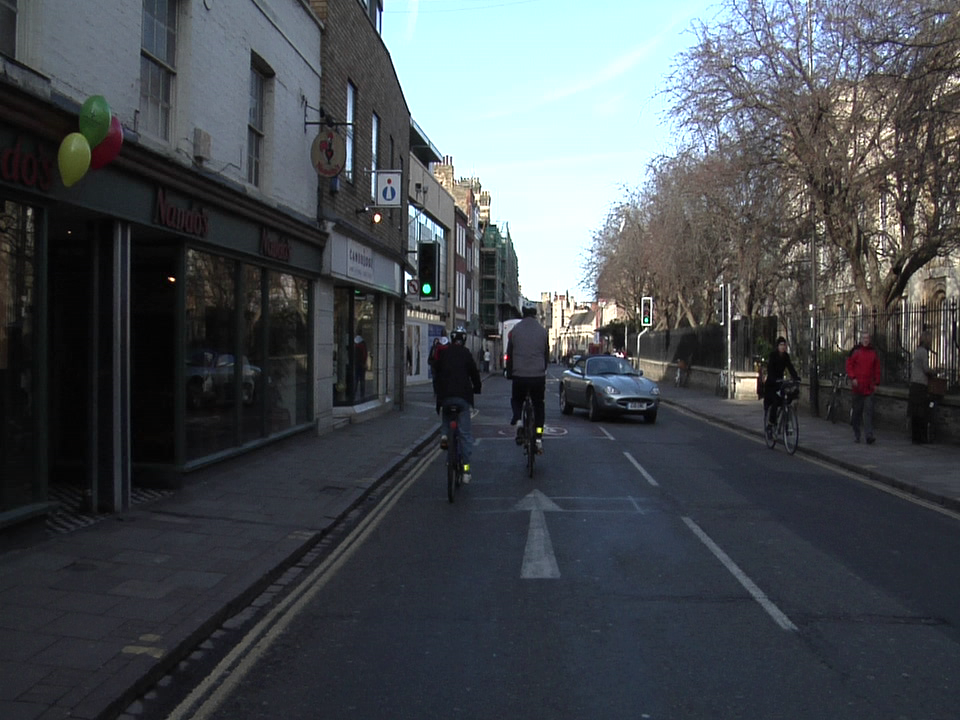

In [7]:
PIL.Image.open(fnames[0])

**Define labels**

In [8]:
def label_func(fn): return path/'labels'/f'{fn.stem}_P{fn.suffix}'

In [9]:
label_func(fnames[0])

Path('/home/innom-dt/.fastai/data/camvid/labels/0016E5_07995_P.png')

**Inspect a segmentation mask**

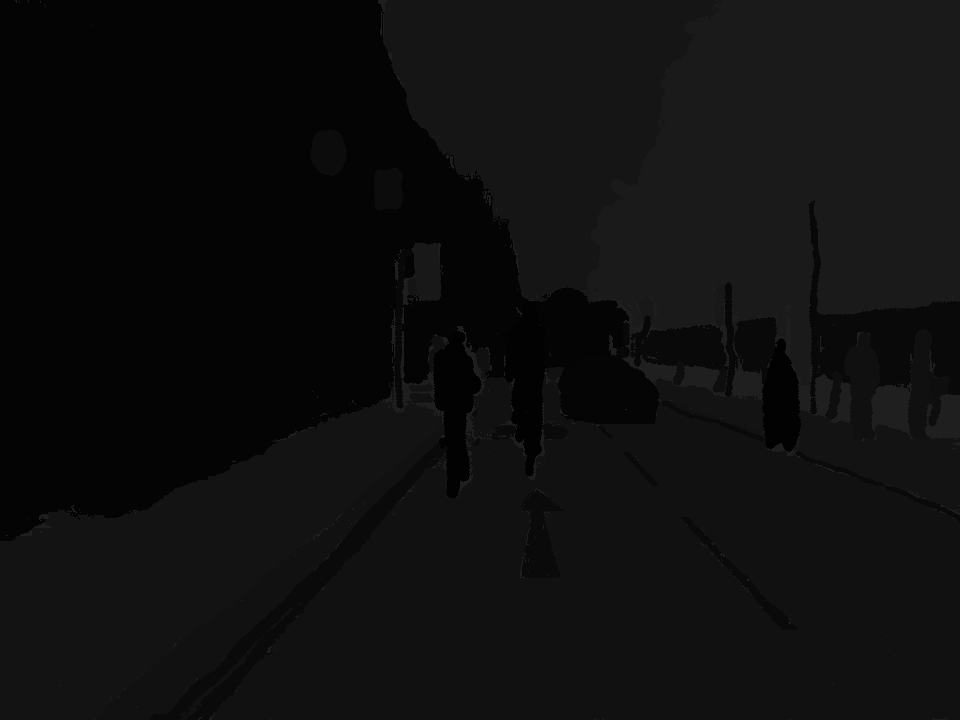

In [10]:
PIL.Image.open(label_func(fnames[0]))

**Define getters**

In [11]:
get_items = get_image_files
get_y = label_func

**Define Transforms**

In [12]:
# batch_tfms = aug_transforms(size=(120,160))
batch_tfms = aug_transforms(size=(240,320))

**Define custom DataBlock**

In [13]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y=get_y,
                   splitter=RandomSplitter(),
                   batch_tfms=batch_tfms
                  )

**Define batch size**

In [14]:
bs = 8

**Inspect SegmentationDataLoaders parameters**

In [15]:
inspect_default_args(SegmentationDataLoaders.from_label_func)

Default Value
cls                 None
path                None
fnames              None
label_func          None
valid_pct            0.2
seed                None
codes               None
item_tfms           None
batch_tfms          None
bs                    64
val_bs              None
shuffle             True
device              None

**Define SegmentationDataLoaders object**

In [16]:
dls = camvid.dataloaders(path/"images", path=path, bs=8)

/home/innom-dt/mambaforge/envs/fastai-base/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


**Verify SegmentationDataLoaders object**

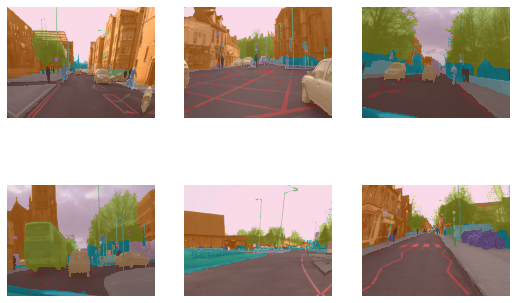

In [17]:
dls.show_batch(max_n=6)

**Inspect Unet Learner Parameters**

In [18]:
inspect_default_args(unet_learner)

Default Value
dls                                                     None
arch                                                    None
normalize                                               True
n_out                                                   None
pretrained                                              True
config                                                  None
loss_func                                               None
opt_func                   <function Adam at 0x7fcaa79d65f0>
lr                                                     0.001
splitter                                                None
cbs                                                     None
metrics                                                 None
path                                                    None
model_dir                                             models
wd                                                      None
wd_bn_bias                                             False
train_bn                                                True
moms                                      (0.95, 0.85, 0.95)
cut                                                     None
n_in                                                       3
blur                                                   False
blur_final                                              True
self_attention                                         False
y_range                                                 None
last_cross                                              True
bottle                                                 False
act_cls           <class 'torch.nn.modules.activation.ReLU'>
init            <function kaiming_normal_ at 0x7fcb706dbbe0>
norm_type                                               None

**Define model**

In [19]:
model = resnet18

**Define Learner object**

In [20]:
learn = unet_learner(dls, model).to_fp16()

/home/innom-dt/mambaforge/envs/fastai-base/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


**Find learning rate**

In [21]:
inspect_default_args(learn.lr_find)

Default Value
self                                          None
start_lr                                       0.0
end_lr                                          10
num_it                                         100
stop_div                                      True
show_plot                                     True
suggest_funcs  <function valley at 0x7fcaa77a1750>

**Define [suggestion methods](https://docs.fast.ai/callback.schedule.html#Suggestion-Methods)**

In [22]:
suggest_funcs = [valley, minimum, steep]

/home/innom-dt/mambaforge/envs/fastai-base/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=4.365158383734524e-05, minimum=0.0003019951749593019, steep=0.00015848931798245758)

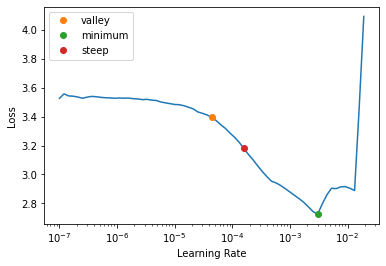

In [23]:
learn.lr_find(suggest_funcs=suggest_funcs)

**Define learning rate**

In [24]:
lr = 5e-4
lr

0.0005

**Define number of epochs**

In [25]:
epochs = 15

In [26]:
learn.fine_tune(epochs, lr)

**Select a test image**

In [27]:
test_file = fnames[0]
test_file.name

'0016E5_07995.png'

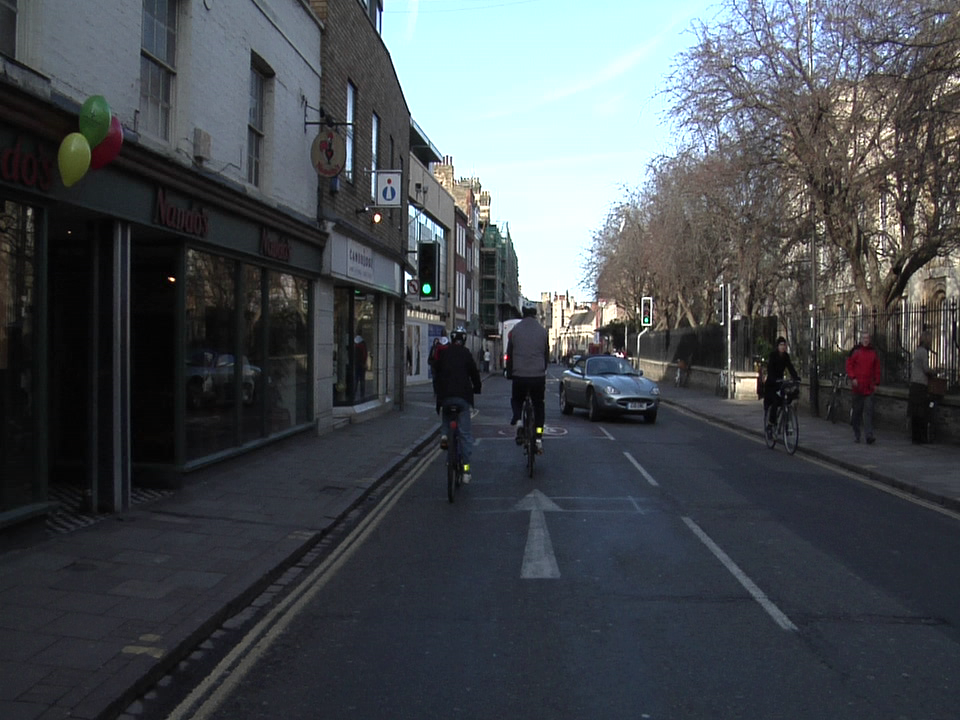

In [28]:
test_img = PIL.Image.open(test_file)
test_img

In [29]:
test_img.shape

(720, 960)

**Make a prediction on a single image using a file path**

In [30]:
preds = learn.predict(test_file)
preds

(TensorMask([[ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]),
 TensorBase([[ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]),
 TensorBase([[[1.3096e-04, 2.2643e-05, 1.3864e-06,  ..., 8.8798e-07,
           1.8052e-05, 2.5005e-04],
          [2.7099e-05, 1.4404e-06, 7.8845e-08,  ..., 2.0313e-08,
           6.1675e-07, 4.0361e-05],
          [1.5920e-06, 5.4611e-08, 4.5007e-09,  ..., 1.1282e-09,
           1.9558e-08, 1.3319e-06],
          ...,
          [1.6537e-05, 1.7137e-06, 6.9173e-08,  ..., 2.1156e-09,
           2.1136e-07, 2.4210e-06],
          [3.3319e-04, 5.0654e-05, 3.1346e-06

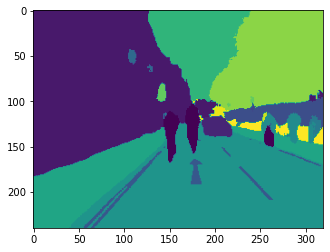

In [31]:
plt.imshow(preds[0].cpu().numpy().astype(np.uint8));

In [32]:
preds[2].shape

torch.Size([32, 240, 320])

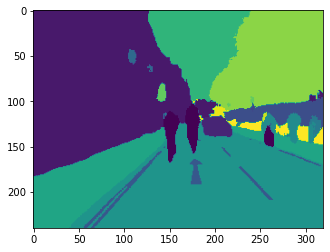

In [33]:
plt.imshow(torch.argmax(preds[2].unsqueeze(dim=0), dim=1).cpu().permute(1,2,0).numpy());

**Make a prediction for a group of images**

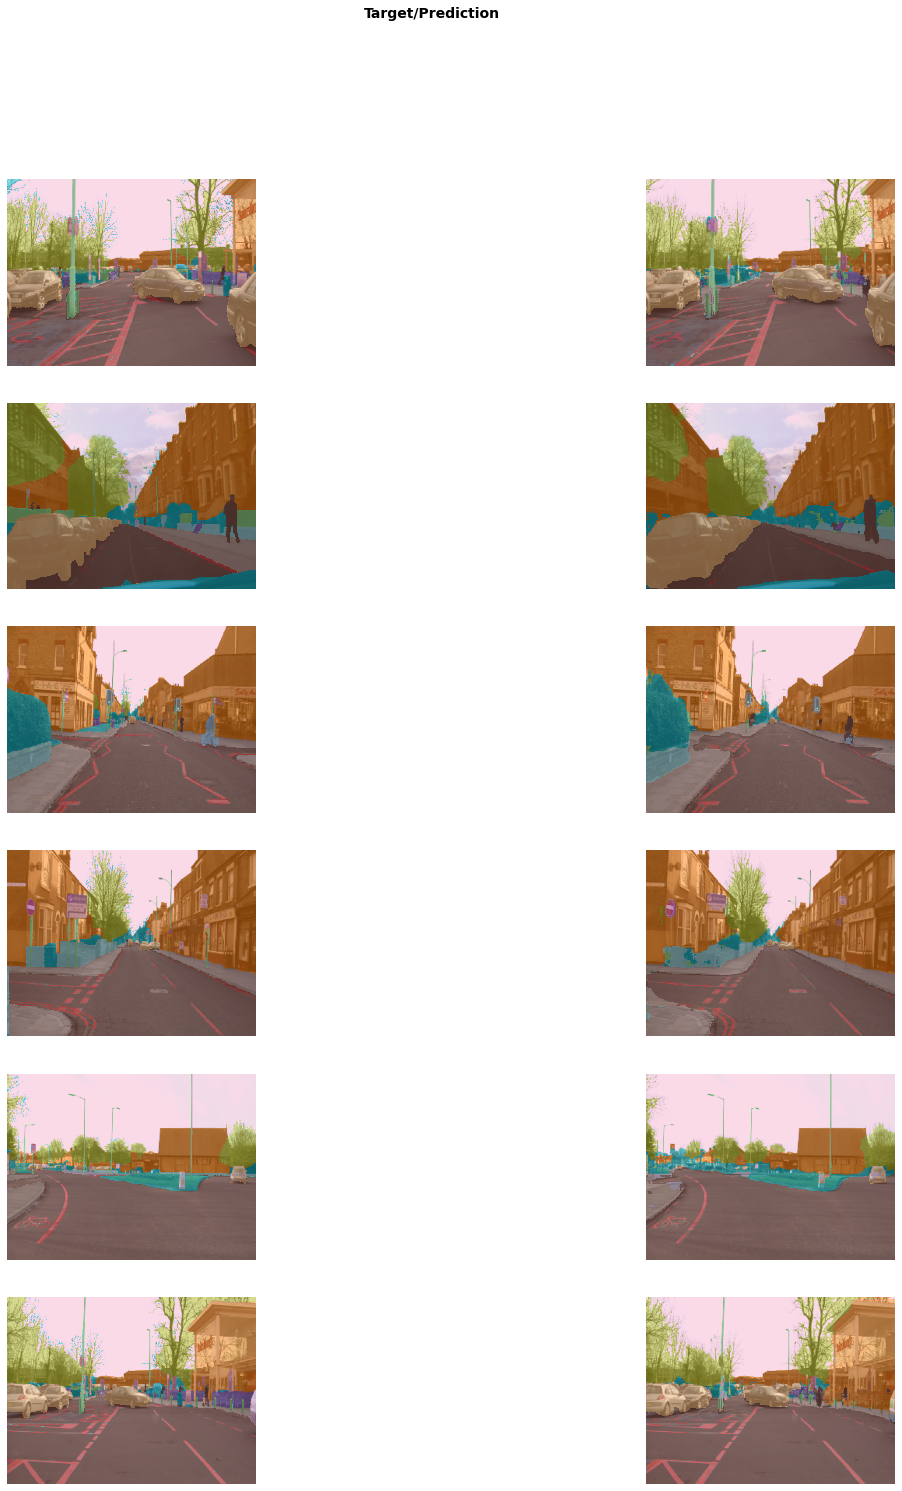

In [34]:
learn.show_results(max_n=6, figsize=(21,24))

**Define an Interpretation object**

In [35]:
inspect_default_args(SegmentationInterpretation.from_learner)

Default Value
cls             None
learn           None
ds_idx             1
dl              None
act             None

In [36]:
interp = SegmentationInterpretation.from_learner(learn)

/home/innom-dt/mambaforge/envs/fastai-base/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


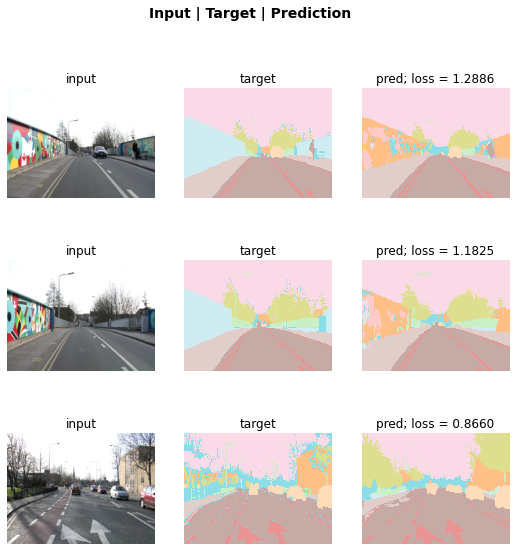

In [37]:
interp.plot_top_losses(k=3)

In [38]:
learn.dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': (240, 320), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

In [39]:
len(codes), codes

(32,
 array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
        'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
        'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
        'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
        'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
        'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
        'VegetationMisc', 'Void', 'Wall'], dtype='<U17'))

**Reset test image**

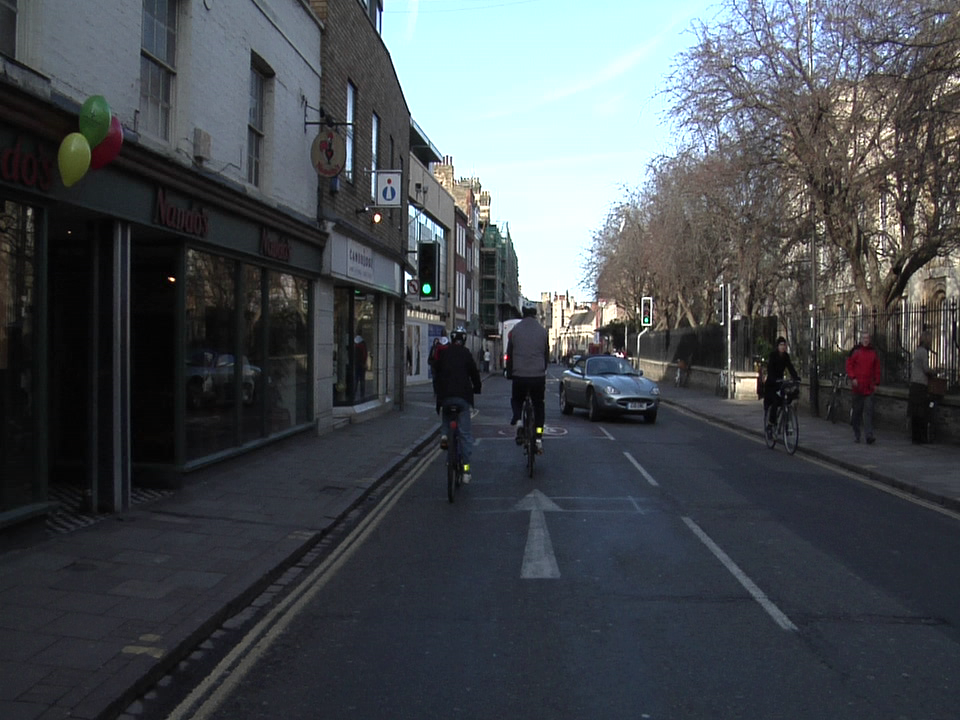

In [40]:
test_img = PIL.Image.open(test_file)
test_img

In [41]:
test_img.size

(960, 720)

**Set input dims**

In [42]:
inp_dims = [320,240]
inp_dims

[320, 240]

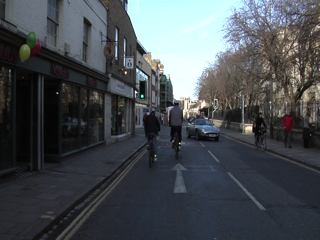

In [43]:
resized_img = test_img.resize(inp_dims)
resized_img

**Convert image to tensor**

In [44]:
img_tensor = tensor(resized_img).permute(2, 0, 1)
img_tensor.shape, img_tensor

(torch.Size([3, 240, 320]),
 tensor([[[ 58,  56,  44,  ...,  93,  92, 100],
          [ 44,  51,  58,  ...,  99,  97,  92],
          [ 43,  41,  42,  ...,  97, 103,  99],
          ...,
          [ 35,  34,  34,  ...,  38,  35,  36],
          [ 35,  35,  36,  ...,  40,  37,  34],
          [ 35,  38,  39,  ...,  41,  40,  36]],
 
         [[ 62,  60,  48,  ...,  92,  88,  95],
          [ 48,  55,  62,  ...,  98,  93,  87],
          [ 47,  44,  45,  ...,  93,  98,  93],
          ...,
          [ 39,  38,  39,  ...,  42,  40,  42],
          [ 38,  38,  38,  ...,  45,  43,  42],
          [ 38,  39,  38,  ...,  45,  45,  43]],
 
         [[ 63,  62,  51,  ...,  95,  92,  93],
          [ 49,  56,  65,  ...,  98,  91,  85],
          [ 49,  46,  49,  ...,  91,  94,  87],
          ...,
          [ 44,  43,  44,  ...,  50,  48,  50],
          [ 44,  44,  44,  ...,  53,  51,  50],
          [ 44,  45,  46,  ...,  54,  56,  53]]], dtype=torch.uint8))

**Scale tensor values**

In [45]:
scaled_tensor = img_tensor.float().div_(255)

**Prepare imagenet mean values**

In [46]:
mean_tensor = tensor(imagenet_stats[0]).view(1,1,-1).permute(2, 0, 1)
mean_tensor.shape, mean_tensor

(torch.Size([3, 1, 1]),
 tensor([[[0.4850]],
 
         [[0.4560]],
 
         [[0.4060]]]))

**Prepare imagenet std values**

In [47]:
std_tensor = tensor(imagenet_stats[1]).view(1,1,-1).permute(2, 0, 1)
std_tensor.shape, std_tensor

(torch.Size([3, 1, 1]),
 tensor([[[0.2290]],
 
         [[0.2240]],
 
         [[0.2250]]]))

**Normalize and batch iamge tensor**

In [48]:
normalized_tensor = (scaled_tensor - mean_tensor) / std_tensor
batched_tensor = normalized_tensor.unsqueeze(dim=0)
batched_tensor.shape, batched_tensor

(torch.Size([1, 3, 240, 320]),
 tensor([[[[-1.1247, -1.1589, -1.3644,  ..., -0.5253, -0.5424, -0.4054],
           [-1.3644, -1.2445, -1.1247,  ..., -0.4226, -0.4568, -0.5424],
           [-1.3815, -1.4158, -1.3987,  ..., -0.4568, -0.3541, -0.4226],
           ...,
           [-1.5185, -1.5357, -1.5357,  ..., -1.4672, -1.5185, -1.5014],
           [-1.5185, -1.5185, -1.5014,  ..., -1.4329, -1.4843, -1.5357],
           [-1.5185, -1.4672, -1.4500,  ..., -1.4158, -1.4329, -1.5014]],
 
          [[-0.9503, -0.9853, -1.1954,  ..., -0.4251, -0.4951, -0.3725],
           [-1.1954, -1.0728, -0.9503,  ..., -0.3200, -0.4076, -0.5126],
           [-1.2129, -1.2654, -1.2479,  ..., -0.4076, -0.3200, -0.4076],
           ...,
           [-1.3529, -1.3704, -1.3529,  ..., -1.3004, -1.3354, -1.3004],
           [-1.3704, -1.3704, -1.3704,  ..., -1.2479, -1.2829, -1.3004],
           [-1.3704, -1.3529, -1.3704,  ..., -1.2479, -1.2479, -1.2829]],
 
          [[-0.7064, -0.7238, -0.9156,  ..., -0.1487, -

**Pass tensor to model**

In [49]:
with torch.no_grad():
    preds = learn.model.cuda()(batched_tensor.cuda())
preds.shape, preds

(torch.Size([1, 32, 240, 320]),
 TensorBase([[[[-3.7191e+00, -4.2203e+00, -5.5083e+00,  ..., -6.7866e+00,
            -5.5598e+00, -3.8000e+00],
           [-4.4008e+00, -6.0866e+00, -7.5380e+00,  ..., -8.7272e+00,
            -7.3937e+00, -5.0136e+00],
           [-5.7116e+00, -7.5779e+00, -8.3712e+00,  ..., -1.0302e+01,
            -9.0910e+00, -6.5236e+00],
           ...,
           [-3.1927e+00, -3.2253e+00, -4.1018e+00,  ..., -4.9034e+00,
            -3.9857e+00, -3.4997e+00],
           [-2.1830e+00, -2.4252e+00, -2.7267e+00,  ..., -3.7007e+00,
            -3.1203e+00, -2.0346e+00],
           [-1.9317e+00, -2.4683e+00, -3.0357e+00,  ..., -3.6950e+00,
            -2.6782e+00, -2.3546e+00]],
 
          [[-1.3561e+00, -9.3985e-01, -1.4263e+00,  ...,  1.5569e+00,
             8.3715e-01,  2.7573e-01],
           [-9.1972e-01, -6.4030e-01, -5.1089e-01,  ...,  2.9307e+00,
             1.2220e+00,  1.9382e-01],
           [-1.1431e+00,  2.7638e-02, -1.2826e-01,  ...,  3.2966e+00,
   

**Process model output**

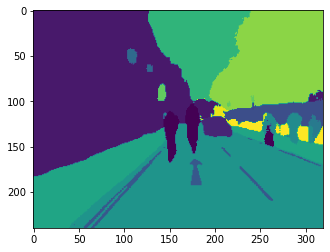

In [50]:
plt.imshow(torch.argmax(preds, dim=1).cpu().permute(1,2,0).numpy());

**Define ONNX file name**

In [51]:
onnx_file_name = f"{path.name}-{learn.arch.__name__}.onnx"
onnx_file_name

'camvid-resnet18.onnx'

**Export trained model to ONNX**

In [52]:
torch.onnx.export(learn.model.cpu(),
                  batched_tensor,
                  onnx_file_name,
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  # Uncomment the line below to unlock input dimensions
                  #dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
                 )

/home/innom-dt/mambaforge/envs/fastai-base/lib/python3.10/site-packages/fastai/vision/models/unet.py:37: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/home/innom-dt/mambaforge/envs/fastai-base/lib/python3.10/site-packages/fastai/vision/models/unet.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


[**Random Color Generator**](https://colordesigner.io/random-color-generator)